# TP : Sentiment analysis on IMDB movie reviews


## Author:

- Gabriele LORENZO
- Aldo PIETROMATERA


## Objectives

1. Implement a simple way to represent text data - Bag of words
2. Implement a basic statistical learning model - Bayesian Naive
3. Use these representations and this model for a sentiment analysis task.
4. Experiment with various way to reduce the vocabulary size and look at the distribution obtained.


## Necessary dependancies

We will need the following packages:

- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html

Both are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn


In [10]:
import os.path as op
import re
import numpy as np
import matplotlib.pyplot as plt

## Loading data

We retrieve the textual data in the variable _texts_.

The labels are retrieved in the variable $y$ - it contains _len(texts)_ of them: $0$ indicates that the corresponding review is negative while $1$ indicates that it is positive.


In [11]:
from glob import glob

# We get the files from the path: ./aclImdb/train/neg for negative reviews, and ./aclImdb/train/pos for positive reviews
train_filenames_neg = sorted(glob("./aclImdb/train/neg/*.txt"))
train_filenames_pos = sorted(glob("./aclImdb/train/pos/*.txt"))

# Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
train_texts_neg = [open(f, encoding="utf8").read() for f in train_filenames_neg]
train_texts_pos = [open(f, encoding="utf8").read() for f in train_filenames_pos]
train_texts = train_texts_neg + train_texts_pos

# The first half of the elements of the list are string of negative reviews, and the second half positive ones

# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
train_labels = np.ones(len(train_texts), dtype=int)
train_labels[: len(train_texts_neg)] = 0.0

In [12]:
open("./aclImdb/train/neg/0_3.txt", encoding="utf8").read()

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

**In this lab, the impact of our choice of representations upon our results will also depend on the quantity of data we use:** try to see how changing the parameter `k` affects our results !


In [13]:
# This number of documents may be high for most computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 10
train_texts_reduced = train_texts[0::k]
train_labels_reduced = train_labels[0::k]

print("Number of documents:", len(train_texts_reduced))

Number of documents: 2500


We can use a function from sklearn, `train_test_split`, to separate data into training and validation sets:


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(
    train_texts_reduced, train_labels_reduced, test_size=0.2
)

## I - Adapted representation of documents

Our statistical model, like most models applied to textual data, uses counts of word occurrences in a document. Thus, a very convenient way to represent a document is to use a Bag-of-Words (BoW) vector, containing the counts of each word (regardless of their order of occurrence) in the document.

If we consider the set of all the words appearing in our $T$ training documents, which we note $V$ (Vocabulary), we can create **an index**, which is a bijection associating to each $w$ word an integer, which will be its position in $V$.

Thus, for a document extracted from a set of documents containing $|V|$ different words, a BoW representation will be a vector of size $|V|$, whose value at the index of a word $w$ will be its number of occurrences in the document.

We can use the **CountVectorizer** class from scikit-learn to obtain these representations:


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin

In [17]:
corpus = [
    "I walked down down the boulevard",
    "I walked down the avenue",
    "I ran down the boulevard",
    "I walk down the city",
    "I walk down the the avenue",
]

vectorizer = CountVectorizer()
Bow = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names_out())
Bow.toarray()

['avenue' 'boulevard' 'city' 'down' 'ran' 'the' 'walk' 'walked']


array([[0, 1, 0, 2, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 2, 1, 0]], dtype=int64)

We display the list containing the words ordered according to their index (Note that words of 2 characters or less are not counted).


### Preprocessing the text: get the BoW representations

The first thing to do is to turn the review from a string into a list of words. The simplest method is to divide the string according to spaces with the command:
`text.split()`

But we must also be careful to remove special characters that may not have been cleaned up (such as HTML tags if the data was obtained from web pages). Since we're going to count words, we'll have to build a list of tokens appearing in our data. In our case, we'd like to reduce this list and make it uniform (ignore capitalization, punctuation, and the shortest words).
We will therefore use a function adapted to our needs - but this is a job that we generally don't need to do ourselves, since there are many tools already adapted to most situations.
For text cleansing, there are many scripts, based on different tools (regular expressions, for example) that allow you to prepare data. The division of the text into words and the management of punctuation is handled in a step called _tokenization_; if needed, a python package like NLTK contains many different _tokenizers_.


In [18]:
# We might want to clean the file with various strategies:
from nltk.tokenize import word_tokenize


def clean_and_tokenize(text):
    """
    Cleaning a document with:
        - Lowercase
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)

    tokens = text.split()
    return tokens


# Or we might want to use an already-implemented tool. The NLTK package has a lot of very useful text processing tools, among them various tokenizers
# Careful, NLTK was the first well-documented NLP package, but it might be outdated for some uses. Check the documentation !

corpus_raw = "I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue."
print(clean_and_tokenize(corpus_raw))
print(word_tokenize(corpus_raw))

<>:23: SyntaxWarning: invalid escape sequence '\['
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\['
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gabriele\AppData\Local\Temp\ipykernel_22416\1857096466.py:23: SyntaxWarning: invalid escape sequence '\['
  REMOVE_PUNCT = re.compile("[.;:!'?,\"()\[\]]")
C:\Users\Gabriele\AppData\Local\Temp\ipykernel_22416\1857096466.py:28: SyntaxWarning: invalid escape sequence '\s'
  REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")


['walked', 'down', 'down', 'the', 'boulevard', 'walked', 'down', 'the', 'avenue', 'ran', 'down', 'the', 'boulevard', 'walk', 'down', 'the', 'city', 'walk', 'down', 'the', 'the', 'avenue']
['I', 'walked', 'down', 'down', 'the', 'boulevard', '.', 'I', 'walked', 'down', 'the', 'avenue', '.', 'I', 'ran', 'down', 'the', 'boulevard', '.', 'I', 'walk', 'down', 'the', 'city', '.', 'I', 'walk', 'down', 'the', 'the', 'avenue', '.']


The next function takes as input a list of documents (each in the form of a string) and returns, as in the example using `CountVectorizer`:

- A vocabulary that associates, to each word encountered, an index
- A matrix, with rows representing documents and columns representing words indexed by the vocabulary. In position $(i,j)$, one should have the number of occurrences of the word $j$ in the document $i$.

The vocabulary, which was in the form of a _list_ in the previous example, can be returned in the form of a _dictionary_ whose keys are the words and values are the indices. Since the vocabulary lists the words in the corpus without worrying about their number of occurrences, it can be built up using a set (in python).

<div class='alert alert-block alert-info'>
            Code:</div>


In [19]:
def count_words(texts):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    vocabulary_set = set(clean_and_tokenize(" ".join(texts)))
    vocabulary = {word: i for i, word in enumerate(vocabulary_set)}

    counts = np.zeros((len(texts), len(vocabulary)))

    for i, text in enumerate(texts):
        for word in clean_and_tokenize(text):
            if word in vocabulary:
                counts[i, vocabulary[word]] += 1
    
    return vocabulary, counts

In [20]:
Voc, X = count_words(corpus)
print(Voc)
print(X)

{'walked': 0, 'down': 1, 'walk': 2, 'avenue': 3, 'ran': 4, 'the': 5, 'city': 6, 'boulevard': 7}
[[1. 2. 0. 0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 1. 0.]
 [0. 1. 1. 1. 0. 2. 0. 0.]]


Now, if we want to represent text that was not available when building the vocabulary, we will not be able to represent **new words** ! Let's take a look at how CountVectorizer does it:


In [21]:
val_corpus = ["I walked up the street"]
Bow = vectorizer.transform(val_corpus)
Bow.toarray()

array([[0, 0, 0, 0, 0, 1, 0, 1]], dtype=int64)

Modify the `count_words` function to be able to deal with new documents when given a previously obtained vocabulary !

<div class='alert alert-block alert-info'>
            Code:</div>


In [22]:
def count_words(texts, voc = None):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    voc : dict
        A dictionary that points to an index in counts for each word - output by a previous use of the function
        If not None, use this one
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    if voc == None:
        vocabulary_set = set(clean_and_tokenize(" ".join(texts)))
        vocabulary = {word: i for i, word in enumerate(vocabulary_set)}
    else:
        vocabulary = voc

    counts = np.zeros((len(texts), len(vocabulary)))

    for i, text in enumerate(texts):
        for word in clean_and_tokenize(text):
            if word in vocabulary:
                counts[i, vocabulary[word]] += 1

    return vocabulary, counts

<div class='alert alert-block alert-warning'>
            Questions:</div>

Careful: check the size that the representations are going to have (given the way they are build). What does this imply for the memory use ? What `CountVectorizer` argument allows to avoid the issue ?

<div class='alert alert-block alert-success'>
            Answer:</div>

The size of the representations is $|V| \times T$, where $|V|$ is the size of the vocabulary and $T$ is the number of documents. This can be very large, especially if the vocabulary is large.

The `CountVectorizer` `max_features` argument allows to limit the size of the vocabulary, and thus the size of the representations. In addition, there are also other arguments that allow to limit the size of the representations, such as `min_df` and `max_df`. We have to add that the default return type of `CountVectorizer` is a sparse matrix, which is a very efficient way to store the data.

<div class='alert alert-block alert-info'>
            Code:</div>


In [23]:
voc, train_bow = count_words(train_texts_splt)
print(train_bow.shape)

(2000, 29908)


In [24]:
_, val_bow = count_words(val_texts, voc)
print(val_bow.shape)

(500, 29908)


In [25]:
# Do the same with a CountVectorizer: create and fit the vectorizer to the training data
vectorizer = CountVectorizer()
train_bow_cv = vectorizer.fit_transform(train_texts_splt).toarray()
print(train_bow_cv.shape)

(2000, 25763)


In [26]:
# Transform the validation data
val_bow_cv = vectorizer.transform(val_texts).toarray()
print(val_bow_cv.shape)

(500, 25763)


## II- Naive Bayesian

### Main idea

A movie review is in fact a list of words $s = (w_1, ..., w_N)$, and we try to find the associated class $c$ - which in our case may be $c = 0$ or $c = 1$. The objective is thus to find for each review $s$ the class $\hat{c}$ maximizing the conditional probability **$P(c|s)$** :

$$\hat{c} = \underset{c}{\mathrm{argmax}}\, P(c|s) = \underset{c}{\mathrm{argmax}}\,\frac{P(s|c)P(c)}{P(s)}$$

**Hypothesis : P(s) is constant for each class** :

$$\hat{c} = \underset{c}{\mathrm{argmax}}\,\frac{P(s|c)P(c)}{P(s)} = \underset{c}{\mathrm{argmax}}\,P(s|c)P(c)$$

**Naive hypothesis : the variables (words) of a review are independant between themselves** :

$$P(s|c) = P(w_1, ..., w_N|c)=\Pi_{i=1..N}P(w_i|c)$$


### General view

#### Training: Estimating the probabilities

For each word $w$ in the vocabulary $V$, $P(w|c)$ is the number of occurrences of $w$ in all reviews of class $c$, divided by the total number of occurrences in $c$. If we note $T(w,c)$ this number of occurrences, we get:

$$P(w|c) = \text{Frequency of }w\text{ in }c = \frac{T(w,c)}{\sum_{w' \in V} T(w',c)}$$

#### Test: Calculating scores

To facilitate the calculations and to avoid _underflow_ and approximation errors, we use the log-sum trick, and we pass the equation into log-probabilities :

$$ \hat{c} = \underset{c}{\mathrm{argmax}} P(c|s) = \underset{c}{\mathrm{argmax}} \left[ \mathrm{log}(P(c)) + \sum_{i=1..N}log(P(w_i|c)) \right] $$

#### Laplace smoothing

A word that does not appear in a document has a probability of zero: this will cause issues with the logarithm. So we keep a very small part of the probability mass that we redistribute with the _Laplace smoothing_:

$$P(w|c) = \frac{T(w,c) + 1}{\sum_{w' \in V} (T(w',c) + 1)}$$

There are other smoothing methods, generally suitable for other, more complex applications.


### Detail: training

The idea is to extract the number of occurrences $T(w,c)$ for each word $w$ and each class $c$, which will make it possible to calculate the matrix of conditional probabilities $\pmb{P}$ such that: $$\pmb{P}_{w,c} = P(w|c)$$

Note that the number of occurrences $T(w,c)$ can be easily obtained from the BoW representations of all documents !

#### Procedure:

- Extract the vocabulary $V$ and counts $T(w,c)$ for each of the words $w$ and classes $c$, from a set of documents.
- Calculate the a priori probabilities of the classes $P(c) = \frac{|\text{documents in class }c|}{|\text{all documents}|}$
- Calculate the conditional **smoothed** probabilities $P(w|c) = \frac{T(w,c) + 1}{\sum_{w' \in V} T(w',c) + 1}$.

### Detail: test

We now know the conditional probabilities given by the $\pmb{P}$ matrix.
Now we must obtain $P(s|c)$ for the current document. This quantity is obtained using a simple calculation involving the BoW representation of the document and $\pmb{P}$.

#### Procedure:

- For each of the classes $c$,
  - $Score(c) = \log P(c)$
  - For each word $w$ in the document to be tested:
    - $Score(c) += \log P(w|c)$
- Return $argmax_{c \in C} Score(c)$


We will therefore be able to use the reviews at our disposal to **estimate the probabilities $P(w|c)$ for each word $w$ given the two classes $c$**. These reviews will allow us to learn how to evaluate the "compatibility" between words and classes.

```python
def fit(self, X, y)
```

**Training**: will learn a statistical model based on the representations $X$ corresponding to the labels $y$.
Here, $X$ contains representations obtained as the output of `count_words`. You can complete the function using the procedure detailed above.

Note: the smoothing is not necessarily done with a $1$ - it can be done with a positive value $\alpha$, which we can implement as an argument of the class "NB".

```python
def predict(self, X)
```

**Testing**: will return the labels predicted by the model for other representations $X$.

<div class='alert alert-block alert-info'>
            Code:</div>


In [27]:
class NB(BaseEstimator, ClassifierMixin):
    # Les arguments de classe permettent l'héritage de classes de sklearn
    def __init__(self, alpha=1.0):
        # alpha is the smoothing parameter: it corresponds to line 10 of the training algorithm
        # By default, we use alpha = 1
        self.alpha = alpha

    def fit(self, X, y):
        self.P_neg = len(y[y == 0]) / len(y)
        self.P_pos = 1 - self.P_neg

        T_w_neg = np.sum(X[y == 0], axis=0)
        T_w_pos = np.sum(X[y == 1], axis=0)

        self.P_w_neg = (T_w_neg + self.alpha) / (
            np.sum(T_w_neg) + self.alpha * X.shape[1]
        )
        self.P_w_pos = (T_w_pos + self.alpha) / (
            np.sum(T_w_pos) + self.alpha * X.shape[1]
        )

        return self

    def predict(self, X):
        score_neg = np.log(self.P_neg) + np.sum(np.log(self.P_w_neg) * X, axis=1)
        score_pos = np.log(self.P_pos) + np.sum(np.log(self.P_w_pos) * X, axis=1)

        return score_pos > score_neg

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

## III - Experimentation

Experiment on this model with your own representations. **Visualize** the results with the following tools, and **compare with the representations of `CountVectorizer`/ naïve Bayes model of scikit-learn `MultinomialNB`:**

<div class='alert alert-block alert-info'>
            Code:</div>


In [28]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

#### My implementation:


In this implementation I used the function `count_words` to obtain the representations. Notice that the function may behave differently than `CountVectorizer`. I used the `fit` function to train the model and the `predict` function to test it.


              precision    recall  f1-score   support

           0       0.74      0.86      0.79       237
           1       0.85      0.73      0.78       263

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.80      0.79      0.79       500



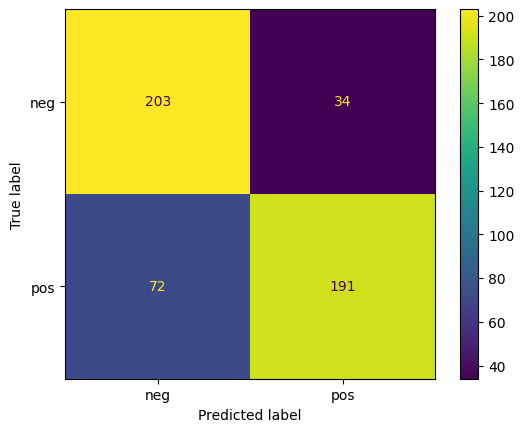

In [29]:
nb = NB()
nb.fit(train_bow, train_labels_splt)

val_pred = nb.predict(val_bow)

print(classification_report(val_labels, val_pred))

cm = confusion_matrix(val_labels, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot()

#### Scikit-learn implementation:


In this implementation, I used the `CountVectorizer` class to obtain the representations. I also used the `MultinomialNB` class to obtain the Naive Bayes model.


              precision    recall  f1-score   support

           0       0.74      0.84      0.79       237
           1       0.84      0.73      0.78       263

    accuracy                           0.78       500
   macro avg       0.79      0.79      0.78       500
weighted avg       0.79      0.78      0.78       500



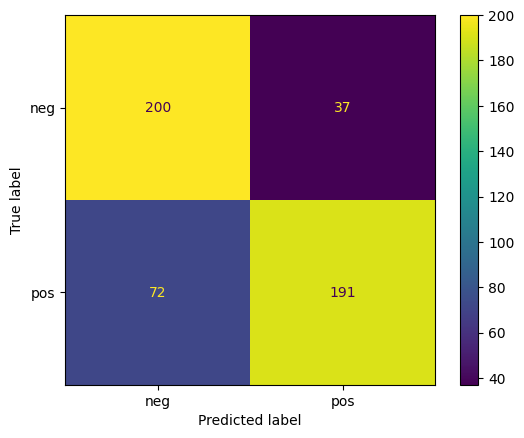

In [30]:
pipeline_base = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("clf", MultinomialNB()),
    ]
)

pipeline_base.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_base.predict(val_texts)

print(classification_report(val_labels, val_pred))

cm = confusion_matrix(val_labels, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot()

<div class='alert alert-block alert-warning'>
            Questions:</div>
            
Let us look at the *features* built by the ```vectorizer```. What seems to be the issue ?

<div class='alert alert-block alert-success'>
            Answer:</div>

The issue here, is that the _features_ built by the `vectorizer` can sometimes not be very informative.
For example, we can see that we have similar features such as "14th" and "14ieme" or "16th" and "16ème". This is due to the fact that the `vectorizer` does not take into account the meaning of the words, and only counts the number of occurrences of each word.


In [31]:
print(vectorizer.get_feature_names_out()[:100])

['00' '000' '007' '0079' '0080' '0083' '01' '02' '05' '07' '08' '10' '100'
 '1000' '100m' '101' '102' '103' '105' '10yr' '11' '112' '12' '120'
 '1200f' '123' '12s' '12th' '13' '130' '13th' '14' '145' '147' '14ieme'
 '14th' '15' '150' '16' '161' '1692' '16th' '16ème' '17' '1700' '1794'
 '1798' '17th' '18' '180' '1800' '1814' '1824' '1840' '1840s' '1850'
 '1880' '1880s' '1889' '1895' '18th' '19' '1902' '1907' '1910' '1911'
 '1912' '1918' '1919' '1920' '1920s' '1921' '1922' '1924' '1925' '1927'
 '1928' '1929' '1930' '1930s' '1931' '1932' '1933' '1934' '1935' '1936'
 '1937' '1938' '1939' '1940' '1940s' '1942' '1943' '1944' '1945' '1946'
 '1947' '1948' '1949' '1950']


### Improving representations

Mainly, the arguments of the class `vectorizer` will allow us to easily change the way our textual data is represented. Let us try to work on our _Bag-of-words_ representations:

#### Do not take into account words that are too frequent:

You can use the argument `max_df=1.0` to change the amount of words taken into account.

#### Try different granularities:

Rather than just counting words, we can count sequences of words - limited in size, of course.
We call a sequence of $n$ words a $n$-gram: let's try using 2 and 3-grams (bi- and trigrams).
We can also try to use character sequences instead of word sequences.

We will be interested in the options `analyze='word'` and `ngram_range=(1, 2)` which we'll change to alter the granularity: **obtain classification results with them**.

Again: using these ways of getting more features from our text will probably have more impact if we do not have much training data to begin with ! To accelerate experiments, use the `Pipeline` tool from scikit-learn.

<div class='alert alert-block alert-info'>
            Code:</div>


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

              precision    recall  f1-score   support

           0       0.74      0.84      0.79       237
           1       0.84      0.73      0.78       263

    accuracy                           0.78       500
   macro avg       0.79      0.79      0.78       500
weighted avg       0.79      0.78      0.78       500



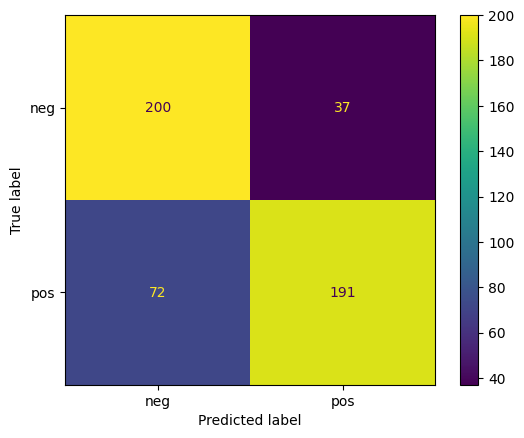

In [33]:
pipeline_base = Pipeline(
    [
        ("vect", CountVectorizer(max_features=30000, analyzer="word", stop_words=None)),
        ("clf", MultinomialNB()),
    ]
)

pipeline_base.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_base.predict(val_texts)

print(classification_report(val_labels, val_pred))

cm = confusion_matrix(val_labels, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot()

              precision    recall  f1-score   support

           0       0.78      0.81      0.80       237
           1       0.83      0.79      0.81       263

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500



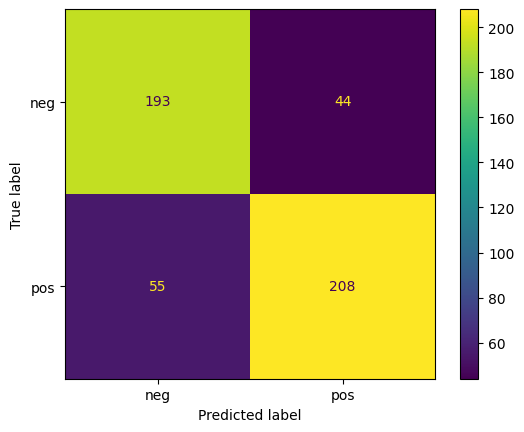

In [34]:
# we split by words and we use 1-3 grams
pipeline_base = Pipeline(
    [
        (
            "vect",
            CountVectorizer(
                max_features=30000, analyzer="word", ngram_range=(1, 3), stop_words=None
            ),
        ),
        ("clf", MultinomialNB()),
    ]
)

pipeline_base.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_base.predict(val_texts)

print(classification_report(val_labels, val_pred))

cm = confusion_matrix(val_labels, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot()

              precision    recall  f1-score   support

           0       0.73      0.80      0.76       237
           1       0.80      0.73      0.76       263

    accuracy                           0.76       500
   macro avg       0.76      0.76      0.76       500
weighted avg       0.77      0.76      0.76       500



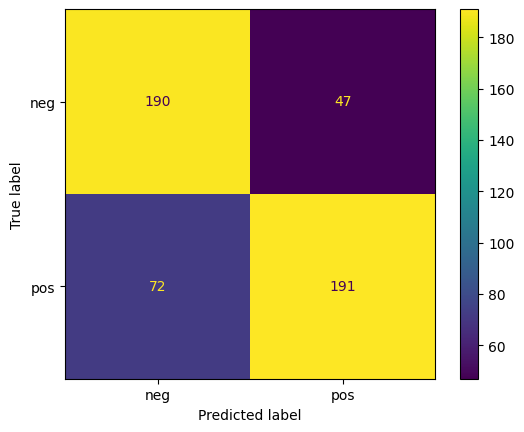

In [35]:
# we split by characters (word bound) and we use 1-4 grams
pipeline_base = Pipeline(
    [
        (
            "vect",
            CountVectorizer(
                max_features=30000,
                analyzer="char_wb",
                ngram_range=(1, 4),
                stop_words=None,
            ),
        ),
        ("clf", MultinomialNB()),
    ]
)

pipeline_base.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_base.predict(val_texts)

print(classification_report(val_labels, val_pred))

cm = confusion_matrix(val_labels, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot()

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       237
           1       0.84      0.79      0.81       263

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



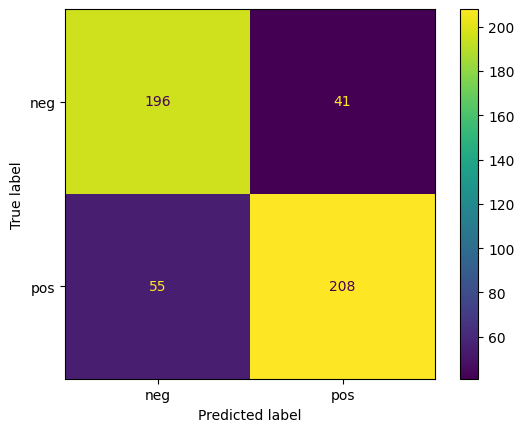

In [36]:
# we split by words and we use 1-3 grams, and limit the frequency of words
pipeline_base = Pipeline(
    [
        (
            "vect",
            CountVectorizer(
                max_features=30000,
                analyzer="word",
                ngram_range=(1, 3),
                stop_words=None,
                max_df=0.6,
            ),
        ),
        ("clf", MultinomialNB()),
    ]
)

pipeline_base.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_base.predict(val_texts)

print(classification_report(val_labels, val_pred))

cm = confusion_matrix(val_labels, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot()

We can see that changing the representation of the data can have a significant impact on the results of our classification.

In our case we experimented with n-grams of words, n-grams of characters and limiting word frequency.


#### Tf-idf:

This is the product of the frequency of the term (TF) and its inverse frequency in documents (IDF).
This method is usually used to measure the importance of a term $i$ in a document $j$ relative to the rest of the corpus, from a matrix of occurrences $ words \times documents$. Thus, for a matrix $\mathbf{T}$ of $|V|$ terms and $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T, w) = \log\left(\frac{D}{|\{d : T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

It can be adapted to our case by considering that the context of the second word is the document. However, TF-IDF is generally better suited to low-density matrices, since it will penalize terms that appear in a large part of the documents.


Experiment with this new representations using the `TfidfTransformer` applied on top of `CountVectorizer`.

<div class='alert alert-block alert-info'>
            Code:</div>


In [37]:
from sklearn.feature_extraction.text import TfidfTransformer

              precision    recall  f1-score   support

           0       0.68      0.92      0.78       237
           1       0.89      0.60      0.72       263

    accuracy                           0.75       500
   macro avg       0.79      0.76      0.75       500
weighted avg       0.79      0.75      0.75       500



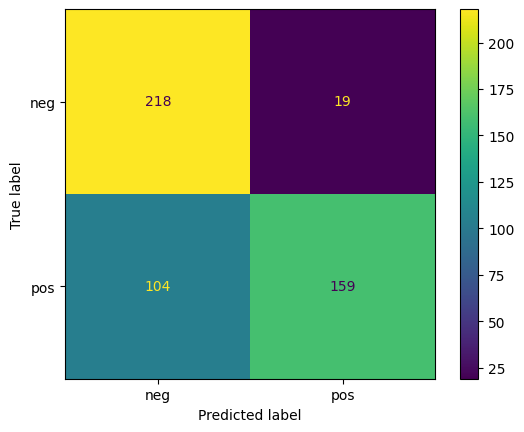

In [38]:
pipeline_base = Pipeline(
    [
        (
            "vect",
            CountVectorizer(max_features=30000, analyzer="word", stop_words=None),
        ),
        ("tfidf", TfidfTransformer()),
        ("clf", MultinomialNB()),
    ]
)

pipeline_base.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_base.predict(val_texts)

print(classification_report(val_labels, val_pred))

cm = confusion_matrix(val_labels, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot()

              precision    recall  f1-score   support

           0       0.74      0.86      0.80       237
           1       0.85      0.73      0.79       263

    accuracy                           0.79       500
   macro avg       0.80      0.80      0.79       500
weighted avg       0.80      0.79      0.79       500



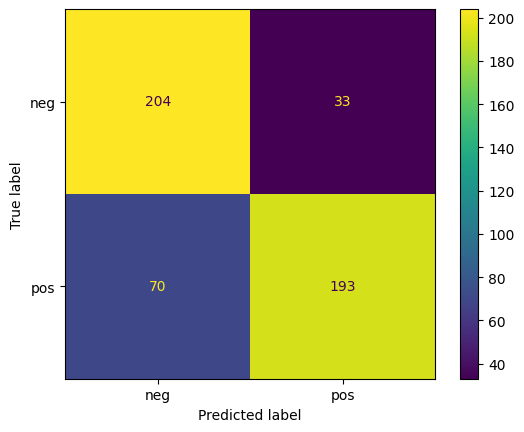

In [39]:
pipeline_base = Pipeline(
    [
        (
            "vect",
            CountVectorizer(
                max_features=30000, analyzer="word", ngram_range=(1, 4), stop_words=None
            ),
        ),
        ("tfidf", TfidfTransformer()),
        ("clf", MultinomialNB()),
    ]
)

pipeline_base.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_base.predict(val_texts)

print(classification_report(val_labels, val_pred))

cm = confusion_matrix(val_labels, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot()

## IV - More pre-processing: getting vocabularies

For more flexibility, we will implement separately a function returning the vocabulary. Here we will have to be able to control its size, either by indicating a **maximum number of words**, or a **minimum number of occurrences** to take the words into account. **We add, at the end, an "unknown" word that will replace all the words that do not appear in our "limited" vocabulary**.

<div class='alert alert-block alert-info'>
            Code:</div>


In [40]:
def vocabulary(corpus, count_threshold=0, voc_threshold=10000):
    """
    Function using word counts to build a vocabulary - can be improved with a second parameter for
    setting a frequency threshold
    Params:
        corpus (list of strings): corpus of sentences
        count_threshold (int): number of occurences necessary for a word to be included in the vocabulary
        voc_threshold (int): maximum size of the vocabulary. Use "0" to indicate no limit
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency
        vocabulary_word_counts (dictionary): keys: list of distinct words across the corpus
                                             values: corresponding counts of words in the corpus
    """
    word_counts = {}

    for sent in corpus:
        for word in word_tokenize(sent):
            word = word.lower()
            word_counts[word] = word_counts.get(word, 0) + 1

    filtered_word_counts = {
        word: count for word, count in word_counts.items() if count >= count_threshold
    }
    sorted_words = sorted(
        filtered_word_counts, key=filtered_word_counts.get, reverse=True
    )
    filtered_words = sorted_words[:voc_threshold] if voc_threshold > 0 else sorted_words
    words = filtered_words + ["UNK"]
    vocabulary = {word: i for i, word in enumerate(words)}

    return vocabulary, {word: filtered_word_counts.get(word, 0) for word in vocabulary}

In [41]:
# Example for testing:

corpus = [
    "I walked down down the boulevard",
    "I walked down the avenue",
    "I ran down the boulevard",
    "I walk down the city",
    "I walk down the the avenue",
]

voc, counts = vocabulary(corpus, count_threshold=3)
print(voc)
print(counts)

# We expect something like this:
# (In this example, we don't count 'UNK' unknown words, but you can if you want to.
# How useful it may be depends on the data -> we will use the counts later with word2vec, keep that in mind)
#  {'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
#  {'down': 6, 'the': 6, 'i': 5, 'UNK': 0}

voc, counts = vocabulary(corpus)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
#  {'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}

{'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
{'down': 6, 'the': 6, 'i': 5, 'UNK': 0}
{'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
{'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}


### Quick study of the data

We would like to get an idea of what's in these film reviews. So we'll get the vocabulary (in full) and represent the frequencies of the words, in order (be careful, you'll have to use a logarithmic scale): we should find back Zipf's law. This will give us an idea of the size of the vocabulary we will be able to choose: it's a matter of making a compromise between the necessary resources (size of the objects in memory) and the amount of information we can get from them (rare words can bring a lot of information, but it's difficult to learn good representations of them, because they are rare!).

<div class='alert alert-block alert-info'>
            Code:</div>


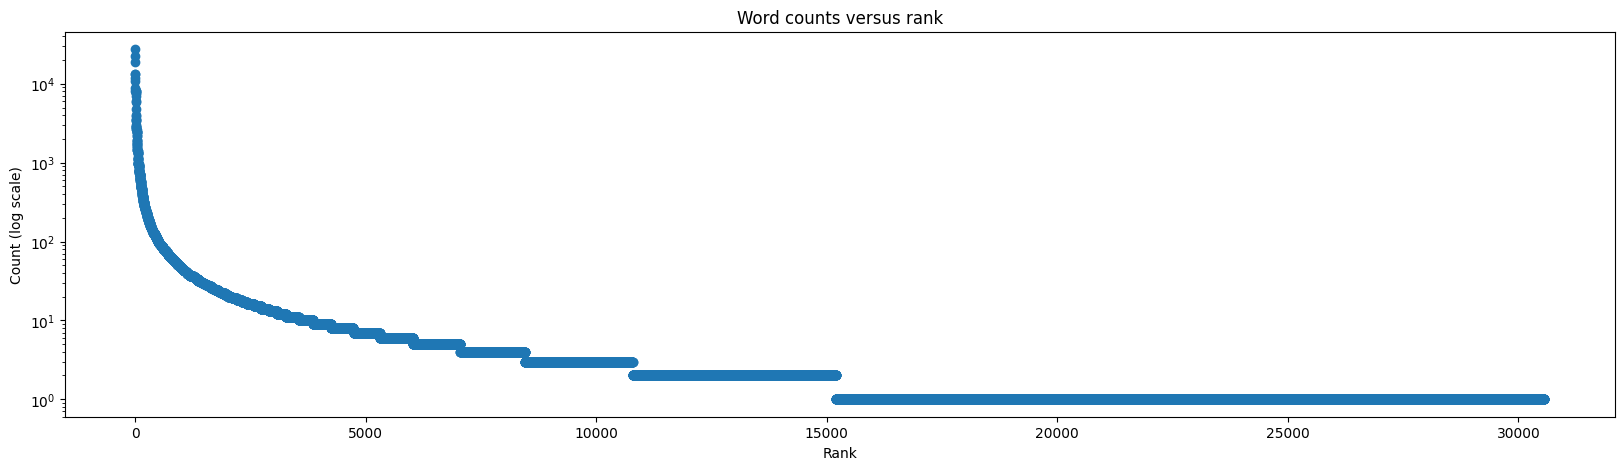

Vocabulary size: 30562
Part of the corpus by taking the "x" most frequent words ?
Part of the corpus by taking the 1000 most frequent words: 0.80


In [42]:
# We would like to display the curve of word frequencies given their rank (index) in the vocabulary
vocab, word_counts = vocabulary(train_texts_splt, voc_threshold=0)

# We can for example use the function plt.scatter()
plt.figure(figsize=(20, 5))
plt.title("Word counts versus rank")
plt.scatter(range(len(word_counts)), sorted(word_counts.values(), reverse=True))
plt.yscale("log")
plt.xlabel("Rank")
plt.ylabel("Count (log scale)")
plt.show()

# We would like to know how much of the data is represented by the 'k' most frequent words
print(f"Vocabulary size: {len(vocab)}")
print('Part of the corpus by taking the "x" most frequent words ?')

k = 1000
expected_proportion = (
    sum(sorted(word_counts.values(), reverse=True)[:k]) / sum(word_counts.values()),
)[0]
print(
    f"Part of the corpus by taking the {k} most frequent words: {expected_proportion:.2f}"
)

<div class='alert alert-block alert-warning'>
            Questions:</div>
            
Word2vec's implementation cuts the vocabulary size by using **only words with at least 5 occurences**, by default. What vocabulary size would it give here ? Does it seem like a good compromise, looking at the graph ?


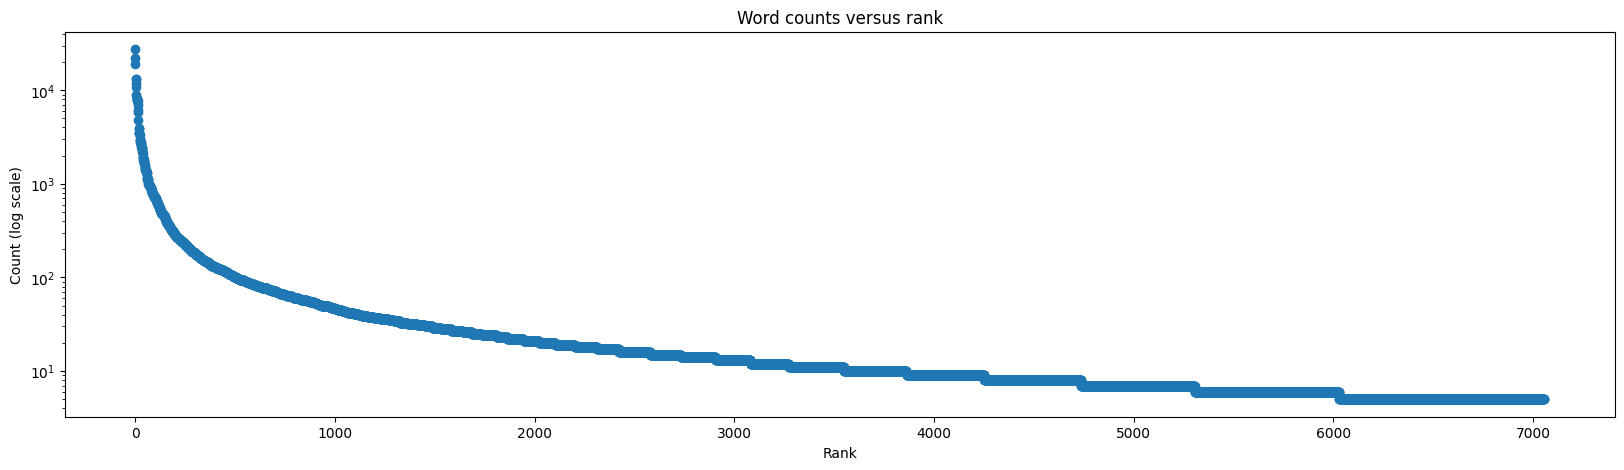

Vocabulary size: 7056
Part of the corpus by taking the "x" most frequent words ?
Part of the corpus by taking the 1000 most frequent words: 0.86


In [43]:
vocab, word_counts = vocabulary(train_texts_splt, count_threshold=5, voc_threshold=0)

plt.figure(figsize=(20, 5))
plt.title("Word counts versus rank")
plt.scatter(range(len(word_counts)), sorted(word_counts.values(), reverse=True))
plt.yscale("log")
plt.xlabel("Rank")
plt.ylabel("Count (log scale)")
plt.show()

print(f"Vocabulary size: {len(vocab)}")
print('Part of the corpus by taking the "x" most frequent words ?')

k = 1000
expected_proportion = (
    sum(sorted(word_counts.values(), reverse=True)[:k]) / sum(word_counts.values()),
)[0]
print(
    f"Part of the corpus by taking the {k} most frequent words: {expected_proportion:.2f}"
)

<div class='alert alert-block alert-success'>
            Answer:</div>

The vocabulary size will be reduced wrt the original size, because we are removing words that appear less than 5 times. This seems like a good compromise, as we can see from the second graph, because we are removing words that are very rare, and that would not be very informative.


### With pre-processing tools from NLTK

We are now going to pre-process our textual data. **Note that this still will only be useful if we do not have a lot of training data to begin with !**


#### Stemming

Allows to go back to the root of a word: you can group different words around the same root, which facilitates generalization. Use:
`from nltk import SnowballStemmer`


In [44]:
from nltk import SnowballStemmer

stemmer = SnowballStemmer("english")

**Example:**


In [45]:
words = ["singers", "cat", "generalization", "philosophy", "psychology", "philosopher"]

for word in words:
    print("word : %s ; stemmed : %s" % (word, stemmer.stem(word)))

word : singers ; stemmed : singer
word : cat ; stemmed : cat
word : generalization ; stemmed : general
word : philosophy ; stemmed : philosophi
word : psychology ; stemmed : psycholog
word : philosopher ; stemmed : philosoph


**Data transformation:**

<div class='alert alert-block alert-info'>
            Code:</div>


In [46]:
def stem(texts):
    stemmed_texts = []

    for text in texts:
        stemmed_text = " ".join([stemmer.stem(word) for word in word_tokenize(text)])
        stemmed_texts.append(stemmed_text)

    return stemmed_texts

#### Part of speech tags

To generalize, we can also use the Part of Speech (POS) of the words, which will allow us to filter out information that is potentially not useful to the model. We will retrieve the POS of the words using the functions:
`pos_tag`


In [47]:
from nltk import pos_tag, word_tokenize

**Example:**


In [48]:
import nltk

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

pos_tag(word_tokenize(("I am Sam")))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gabriele\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Gabriele\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('I', 'PRP'), ('am', 'VBP'), ('Sam', 'NNP')]

**Data transformation:** only keep nouns, verbs, adverbs, and adjectives (`['NN', 'VB', 'ADJ', 'RB']`) for our model.

<div class='alert alert-block alert-info'>
            Code:</div>


In [49]:
def pos_tag_filter(X, good_tags=["NN", "VB", "RB", "JJ"]):
    X_pos = []

    for text in X:
        pos_tags = pos_tag(word_tokenize(text))
        pos_tags = [
            word for word, tag in pos_tags if tag in good_tags
        ]
        X_pos.append(" ".join(pos_tags))

    return X_pos

### Application

<div class='alert alert-block alert-warning'>
            Questions:</div>

Re-draw the Zipf distribution of our data **after reducing their vocabulary with these functions**. How is it affected ? How do you think it could affect results here ?

<div class='alert alert-block alert-info'>
            Code:</div>


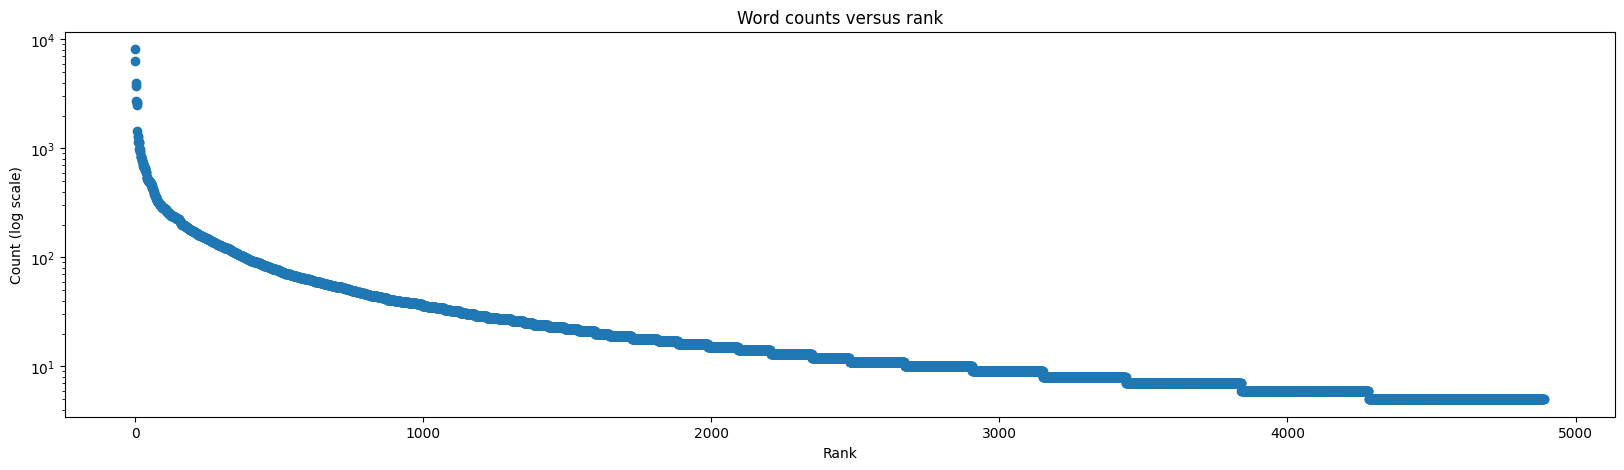

Vocabulary size: 4892
Part of the corpus by taking the "x" most frequent words ?
Part of the corpus by taking the 1000 most frequent words: 0.78


In [50]:
stemmed_train_texts = stem(train_texts_splt)
pos_tagged_train_texts = pos_tag_filter(stemmed_train_texts)

vocab, word_counts = vocabulary(pos_tagged_train_texts, count_threshold=5, voc_threshold=0)

plt.figure(figsize=(20, 5))
plt.title("Word counts versus rank")
plt.scatter(range(len(word_counts)), sorted(word_counts.values(), reverse=True))
plt.yscale("log")
plt.xlabel("Rank")
plt.ylabel("Count (log scale)")
plt.show()

print(f"Vocabulary size: {len(vocab)}")
print('Part of the corpus by taking the "x" most frequent words ?')

k = 1000
expected_proportion = (
    sum(sorted(word_counts.values(), reverse=True)[:k]) / sum(word_counts.values()),
)[0]
print(
    f"Part of the corpus by taking the {k} most frequent words: {expected_proportion:.2f}"
)

<div class='alert alert-block alert-success'>
            Answer:</div>

The Zipf distribution will be affected by the reduction of the vocabulary. As we have said before, the reduction of the vocabulary will remove unfrequent and non-informative words. In fact, with the stemming process we are reducing the vocabulary size wile keeping the information. With the POS tagging, we are also removing non-informative words in our analysis domain (for example, we could not be interested in adverbs or prepositions).
